In [1]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [2]:
%load_ext autoreload
%autoreload 2

# Wiki10-31k

> API details

In [3]:
import fastbook
fastbook.setup_book()

from fastbook import *

Application specific imports

In [4]:
from fastai.text.all import *
from fastai.distributed import *

from xcube.text.learner import text_classifier_learner
from xcube.metrics import PrecisionK

#### Setting the base path as the path of the repository

In [5]:
path = Path.cwd()
path_data = path/'data'
path_model = path/'models'

path_model.mkdir(exist_ok=True)
path_data.mkdir(exist_ok=True)

file_prefix = 'wiki10-31k'

data = path_data/(file_prefix+'.csv')
dls_lm_path = path_model/f"{file_prefix}_dls_lm.pkl"
dls_lm_vocab_path = path_model/f"{file_prefix}_dls_lm_vocab.pkl"
dls_clas_path = path_model/f"{file_prefix}_dls_clas.pkl"

print(f"{ path = },\n {path_data = },\n {path_model = },\n {file_prefix = },\n {data = },\n {dls_lm_path =},\n {dls_lm_vocab_path = },\n {dls_clas_path = }.")

 path = Path('/home/deb/xcube/nbs/examples/wiki10-31k'),
 path_data = Path('/home/deb/xcube/nbs/examples/wiki10-31k/data'),
 path_model = Path('/home/deb/xcube/nbs/examples/wiki10-31k/models'),
 file_prefix = 'wiki10-31k',
 data = Path('/home/deb/xcube/nbs/examples/wiki10-31k/data/wiki10-31k.csv'),
 dls_lm_path =Path('/home/deb/xcube/nbs/examples/wiki10-31k/models/wiki10-31k_dls_lm.pkl'),
 dls_lm_vocab_path = Path('/home/deb/xcube/nbs/examples/wiki10-31k/models/wiki10-31k_dls_lm_vocab.pkl'),
 dls_clas_path = Path('/home/deb/xcube/nbs/examples/wiki10-31k/models/wiki10-31k_dls_clas.pkl').


## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki10-31k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [9]:
# !head -n 1 {data}

In [6]:
df = pd.read_csv(data, header=0, names=['text', 'labels', 'is_valid'], dtype={'text': str, 'labels': str})

In [7]:
len(df)

20762

In [8]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [9]:
df.head(3)

,text,labels,is_valid
0,"Hermann Zapf (born November 8, 1918) is a German typeface designer who lives in Darmstadt, Germany. He is married to calligrapher and typeface designer Gudrun Zapf von Hesse. Zapf's work has suffered the two-edged sword of veneration, as his designs, which include Palatino and Optima, have been widely admired yet perhaps the most egregiously plagiarized of the twentieth century. The best known example may be Monotype's Book Antiqua, which shipped with Microsoft Office and was widely considered a ""knockoff"" of Palatino. In 1993, Zapf resigned from ATypI (Association Typographique Internatio...","2980,3177,9026,9053,12256,12258,14385,14548,21806,23227,24101,24485,25398,28816,28825,28828,28835,28838,28840,30071,30134,30708,30709",False
1,"""Yakety Sax"" is a 1963 45 rpm single written by Boots Randolph and James Q. ""Spider"" Rich, and recorded by Boots Randolph. The composition includes pieces of assorted fiddle tunes such as ""Chicken Reel"", and written for a performance at a venue called The Armory in Hopkinsville, Kentucky. There is also a bar of ""Entrance of the Gladiators"" worked into it. This piece of music is not to be confused with the Leiber and Stoller song ""Yakety Yak"", recorded in 1958 by The Coasters. The tunes are similar, and both feature the ""yakety sax"" sound, but are distinctly different melodies. Randolph had...","4188,14485,14932,20047,20085,20165,24290,26519,27814,29121,30134,30177",False
2,"TORX, developed by Camcar LLC of Acument Global Technologies (formerly Camcar Textron), is the trademark for a type of screw head characterized by a 6-point star-shaped pattern (in the same way that slotted heads, Phillips, hex socket, and Robertson have linear, cruciform, hexagonal, and square tips, respectively). People unfamiliar with the trademark generally use the term star, as in star screwdriver or star bits. The generic name is hexalobular internal driving feature and is standardised by the International Organization for Standardization as ISO 10664. TORX is frequently styled Torx ...","1416,4633,9483,9580,12288,12290,14123,21775,24290,25348,25349,28376,28828,30071,30134,30546",False


**Data Cleaning**

In [11]:
def removenum(matchobj):
    if str.isnumeric(matchobj.group(0)): return ''
    else:  return matchobj.group(0)

In [12]:
pat = re.compile('\w+')
def process(txt):
    txt = txt.lower().translate(str.maketrans('', '', string.punctuation))
    return pat.sub(removenum, txt)

In [13]:
df['text'] = df['text'].apply(lambda x: process(x))

We will now create the `DataLoaders` using `DataBlock` API:

In [10]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [11]:
dls_lm.show_batch(max_n=2)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,"xxbos xxmaj cory xxmaj anthony xxmaj booker ( born xxmaj april 27 , 1969 ) is the current xxmaj mayor of xxmaj newark , xxmaj new xxmaj jersey . xxmaj he is a xxmaj democratic politician and former xxmaj newark xxmaj councilman and community activist who ran unsuccessfully for mayor in 2002 against longtime incumbent xxmaj sharpe xxmaj james . xxmaj booker ran again in 2006 and won a sweeping victory against xxmaj ronald xxmaj rice to become the 36th","xxmaj cory xxmaj anthony xxmaj booker ( born xxmaj april 27 , 1969 ) is the current xxmaj mayor of xxmaj newark , xxmaj new xxmaj jersey . xxmaj he is a xxmaj democratic politician and former xxmaj newark xxmaj councilman and community activist who ran unsuccessfully for mayor in 2002 against longtime incumbent xxmaj sharpe xxmaj james . xxmaj booker ran again in 2006 and won a sweeping victory against xxmaj ronald xxmaj rice to become the 36th mayor"
1,", the terms xxmaj xxunk / xxmaj hindi were used ) . xxmaj by 1850 , xxmaj hindi and xxmaj urdu were no longer used for the same language . xxmaj other linguists such as xxmaj sir xxup g. xxup a. xxmaj grierson ( 1903 ) have also claimed that xxmaj urdu is simply a dialect or style of xxmaj western xxmaj hindi . xxmaj before the xxmaj partition of xxmaj india , xxmaj delhi , xxmaj lucknow , xxmaj","the terms xxmaj xxunk / xxmaj hindi were used ) . xxmaj by 1850 , xxmaj hindi and xxmaj urdu were no longer used for the same language . xxmaj other linguists such as xxmaj sir xxup g. xxup a. xxmaj grierson ( 1903 ) have also claimed that xxmaj urdu is simply a dialect or style of xxmaj western xxmaj hindi . xxmaj before the xxmaj partition of xxmaj india , xxmaj delhi , xxmaj lucknow , xxmaj xxunk"


The length of our vocabulary is:

In [12]:
len(dls_lm.vocab)

60008

Let's take a look at some words of the vocab:

In [13]:
print(coll_repr(L(dls_lm.vocab), 30))

(#60008) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the',',','.','of','and','in','to','a','is','"','-','as',']','that','(',')','for','by','was','with','on'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use):

In [14]:
torch.save(dls_lm, dls_lm_path)
torch.save(dls_lm.vocab, dls_lm_vocab_path)

To load back the `dls_lm` later on:

In [6]:
dls_lm = torch.load(dls_lm_path)

## `Learner` for the Language Model Fine-Tuning:

In [7]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

Let's compute the learning rate using the `lr_find`:

(0.014454397559165954,
 7.585775847473997e-07,
 0.0014454397605732083,
 0.013182567432522774)

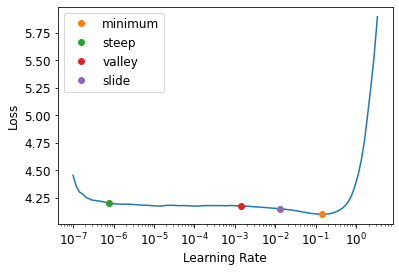

In [8]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [41]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.706824,3.599593,0.358753,36.583355,30:25


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

In [46]:
learn.save('1epoch')

Path('models/1epoch.pth')

Let's now load back the `Learner`

In [16]:
learn = learn.load('1epoch')

Let's validate the `Learner` to make sure we loaded the correct version:

In [17]:
learn.validate()

(#3) [3.5995934009552,0.3587533235549927,36.58335494995117]

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [20]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit_one_cycle(10, lr_max=2e-3, cbs=SaveModelCallback(fname=path_model/'wiki-500k_lm'))

Note: Make sure if you have trained the most language model `Learner` for more epochs (then you need to save that version)

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [18]:
learn.save_encoder('finetuned')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the Multi-Label Classifier (using fastai's Mid-Level Data API)

### Loading Raw Data

In [23]:
data

Path('/home/deb/xcube/nbs/examples/wiki10-31k/data/wiki10-31k.csv')

In [19]:
df = pd.read_csv(data, dtype={'text': str, 'labels': str})
df[['text', 'labels']] = df[['text', 'labels']].astype('str')

In [20]:
df.head(3)

,text,labels,is_valid
0,"Hermann Zapf (born November 8, 1918) is a German typeface designer who lives in Darmstadt, Germany. He is married to calligrapher and typeface designer Gudrun Zapf von Hesse. Zapf's work has suffered the two-edged sword of veneration, as his designs, which include Palatino and Optima, have been widely admired yet perhaps the most egregiously plagiarized of the twentieth century. The best known example may be Monotype's Book Antiqua, which shipped with Microsoft Office and was widely considered a ""knockoff"" of Palatino. In 1993, Zapf resigned from ATypI (Association Typographique Internatio...","2980,3177,9026,9053,12256,12258,14385,14548,21806,23227,24101,24485,25398,28816,28825,28828,28835,28838,28840,30071,30134,30708,30709",False
1,"""Yakety Sax"" is a 1963 45 rpm single written by Boots Randolph and James Q. ""Spider"" Rich, and recorded by Boots Randolph. The composition includes pieces of assorted fiddle tunes such as ""Chicken Reel"", and written for a performance at a venue called The Armory in Hopkinsville, Kentucky. There is also a bar of ""Entrance of the Gladiators"" worked into it. This piece of music is not to be confused with the Leiber and Stoller song ""Yakety Yak"", recorded in 1958 by The Coasters. The tunes are similar, and both feature the ""yakety sax"" sound, but are distinctly different melodies. Randolph had...","4188,14485,14932,20047,20085,20165,24290,26519,27814,29121,30134,30177",False
2,"TORX, developed by Camcar LLC of Acument Global Technologies (formerly Camcar Textron), is the trademark for a type of screw head characterized by a 6-point star-shaped pattern (in the same way that slotted heads, Phillips, hex socket, and Robertson have linear, cruciform, hexagonal, and square tips, respectively). People unfamiliar with the trademark generally use the term star, as in star screwdriver or star bits. The generic name is hexalobular internal driving feature and is standardised by the International Organization for Standardization as ISO 10664. TORX is frequently styled Torx ...","1416,4633,9483,9580,12288,12290,14123,21775,24290,25348,25349,28376,28828,30071,30134,30546",False


let's now gather the labels from the 'labels' column of the df:

In [21]:
label_freq = Counter()
for labels in df.labels: label_freq.update(labels.split(','))

The total number of labels are:

In [22]:
len(label_freq)

30938

Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [23]:
lbls = list(label_freq.keys()) 

### Steps for creating the classifier `DataLoaders` using fastai `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [25]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#14146) [0,1,2,3,4,5,6,7,8,9...],
 (#6616) [14146,14147,14148,14149,14150,14151,14152,14153,14154,14155...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [26]:
lm_vocab = torch.load(dls_lm_vocab_path)

In [27]:
L(lm_vocab)

(#60008) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [16]:
@Transform
def Shrink(num:TensorText): return num[:2500] if len(num)>2500 else num

In [28]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)] 
y_tfms = [ColReader('labels', label_delim=','), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]

In [29]:
dsets = Datasets(df, tfms, splits=splits)

Let's now check if our `Datasets` got created alright:

In [30]:
len(dsets.train), len(dsets.valid)

(14146, 6616)

In [31]:
dsets.train[0]

(TensorText([   2,    8, 8201,  ...,    0,    0,   21]),
 TensorMultiCategory([1., 1., 1.,  ..., 0., 0., 0.]))

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size:

In [32]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [33]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [34]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                        dl_type=dl_type,
                       before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so let's save it:

In [11]:
torch.save(dls_clas, dls_clas_path)

Let's take a look at the data:

In [35]:
dls_clas.show_batch(max_n=3)

/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/deb/miniconda3/lib/python3.9/site-packages/fastai/torch_core.py:475: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/hom

,text,None
0,xxbos xxmaj adolf xxmaj hitler in 1933 xxmaj pogroms : xxmaj kristallnacht · xxmaj bucharest · xxmaj xxunk · xxmaj iaşi · xxmaj kaunas · xxmaj xxunk · xxmaj lviv xxmaj ghettos : xxunk · łódź · xxmaj lwów · xxmaj kraków · xxmaj budapest · xxmaj theresienstadt · xxmaj kovno · xxmaj vilna · xxmaj warsaw xxmaj einsatzgruppen : xxmaj xxunk xxmaj yar · xxmaj xxunk · xxmaj xxunk · xxmaj odessa · xxmaj xxunk · xxmaj ninth xxmaj fort xxmaj final xxmaj solution : xxmaj wannsee · xxmaj operation xxmaj reinhard · xxmaj holocaust trains xxmaj concentration camps : auschwitz - birkenau · xxmaj xxunk · xxmaj chełmno · xxmaj majdanek · xxmaj sobibór · xxmaj treblinka · xxmaj xxunk,14548;30134;22146;30392;15584;4427;17686;11212;1374;2014;13205;20424;9220;13195;9228;19586;14596;14665;3802;30517;8644;11261;9773;14733;538;1756;1758
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,14548;30134;30459;30392;3093;24130;24553;19432;21792;27679;3165;3152;3101;19815;21789;30920;30929;819
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,14548;24485;30071;30134;15155;10794;22878;24384;25224;8002;29744;13102;14927;8006;28406;18650;28947;25633;13897;8533;14926;4942


In [24]:
dls_clas = torch.load(dls_clas_path)

## `Learner` for Multi-Label Classifier Fine-Tuning

In [6]:
dls_clas = torch.load(dls_clas_path)

In [7]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*20, metrics=partial(PrecisionK, k=5)).to_fp16()

In [8]:
learn = learn.load_encoder('finetuned')

## Fine-Tuning the Classifier 

In [27]:
# lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
# lr_min, lr_steep, lr_valley, lr_slide

In [9]:
learn.fit_one_cycle(1, lr_max=1e-1, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,PrecisionK,time
0,0.003674,0.003529,0.606137,15:38


In [12]:
learn.save('model')

Path('models/model.pth')

In [13]:
learn = learn.load('model')

In [18]:
learn.metrics = partial(PrecisionK, k=19)

In [19]:
learn.validate()

(#2) [0.0035288804210722446,0.31026061223190976]

In [11]:
learn.freeze_to(-2)

In [ ]:
learn.fit_one_cycle(8, lr_max=1e-2, moms=(0.8,0.7,0.8), wd=0.1, cbs=SaveModelCallback())

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3, moms=(0.8,0.7,0.8), wd=0.4, cbs=SaveModelCallback(fname=path_model/'caml_clas_sample_10percent'))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-4, moms=(0.8,0.7,0.8), wd=0.4)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));